In [1]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import pandas as pd
from matplotlib import pyplot as plt

def boolify(s):
    if s == 'True':
        return True
    if s == 'False':
        return False
    raise ValueError("Didn't boolify")

def autoconvert(s):
    for fn in (boolify, int, float):
        try:
            return fn(s)
        except ValueError:
            pass
    return s[1:-1] # strips off beginning and ending '

class Experiment:
    def __init__(self, logfile):
        
        self.logfile = logfile
        f = open(logfile+'/exp.log','r')
        log = f.readlines()
        f.close()
        
        self.log = log
        
        ##
        # Parse information that defines the experiment
        
        namespace_lines = [line for line in log if "Namespace" in line]
        exp_info = namespace_lines[0]
        exp_info_splits = exp_info[exp_info.index('(')+1:-1].split(', ')
        exp_info_pairs = [s.split('=') for s in exp_info_splits]
        
        self.info = {}
        for pair in exp_info_pairs: 
            self.info[pair[0]] = autoconvert(pair[1])
            
        ##
        # Read information from different epochs and create DataFrame
    
        self.epoch_lines = [line for line in log if line[:5] == "Epoch"]
        self.epochs, self.wassersteins, self.log_wassersteins = [], [], []
        for line in self.epoch_lines:
            s = line.split(' ')
            
            # parse data
            epoch = int(s[1][1:s[1].index('/')])#; print(epoch)
            num_epochs = int(s[1][s[1].index('/')+1:s[1].index(']')])#; print(num_epochs)
            wass = float(s[3][0:s[3].index(',')])#; print(wass)
            log_wass = float(s[5][0:s[5].index('\n')])#; print(log_wass)
            
            # store data
            self.epochs.append(epoch)
            self.wassersteins.append(wass)
            self.log_wassersteins.append(log_wass)
            
        self.num_epochs = num_epochs
        
        self.data_dict = {'Epoch': self.epochs, 
                          'Wassersteins': self.wassersteins, 
                          'Log Wassersteins': self.log_wassersteins,
                          'h11': ["$"+str(self.info['h11'])+"$" for e in self.epochs],
                          'model_type': [self.info['model_type'] for e in self.epochs],
                          'nz': ["$"+str(self.info['nz'])+"$" for e in self.epochs],
                          'lrG': ["$"+str(self.info['lr_G'])+"$" for e in self.epochs],
                          'lrD': ["$"+str(self.info['lr_D'])+"$" for e in self.epochs],
                         }
        
        self.data = pd.DataFrame(self.data_dict)
        
    def performance_plot(self, show = True, log = False):
        if not log:
            sns.lmplot(x="Epoch", y="Wassersteins", data = self.data)
        else:
            sns.lmplot(x="Epoch", y="Log Wassersteins", data = self.data)
            
        if show: plt.show()

def extract_log_data(exp):
    
    exp_obj = Experiment(data)
    return exp_obj
    
import os

exp_root = "experiments/"

files = [exp_root + k for k in os.listdir(exp_root) if 'exp' in k]
experiments = [Experiment(file) for file in files]

print("Number of experiments to analyze:", len(experiments))

('Number of experiments to analyze:', 160)


In [31]:
all_data = experiments[0].data
for exp in experiments[1:]:
    all_data = pd.concat([all_data,exp.data], ignore_index=True)
    
all_data = all_data.reset_index(drop=True)
    

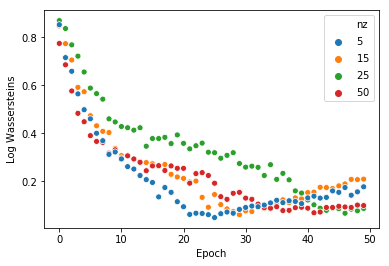

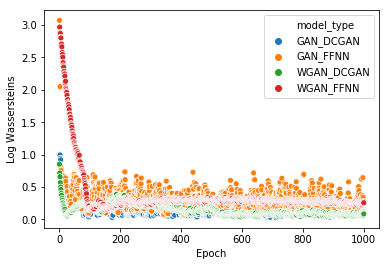

In [32]:
def cut(data,key,val):
    return data[data[key]==val]

def cut_mod(data,key,mod,val):
    return data[data[key]%mod==val]

def cut_greater(data,key,val):
    return data[data[key] > val]

def cut_less(data,key,val):
    return data[data[key] < val]

d = cut(all_data,'model_type','WGAN_DCGAN')
#d = cut_greater(d,'Epoch',0)
d = cut_less(d,'Epoch',50)
d = cut(d,'h11','$10$')
d = cut(d,'lrG','$5e-06$')
d = cut_mod(d,'Epoch',1,0)
sns.scatterplot(x="Epoch", y="Log Wassersteins", data = d, hue='nz', hue_order = ['$5$', '$15$', '$25$', '$50$'])
plt.show()

d = cut(all_data,'nz','$5$')
#d = cut_greater(d,'Epoch',0)
#d = cut_less(d,'Epoch',50)
d = cut(d,'h11','$10$')
d = cut(d,'lrG','$5e-06$')
d = cut_mod(d,'Epoch',1,0)
sns.scatterplot(x="Epoch", y="Log Wassersteins", data = d, hue='model_type')
plt.show()


In [37]:
for h11 in ['$10$','$20$','$30$','$40$','$50$']:
    cur = cut(all_data,'h11',h11)
    #cur = cut(cur,'model_type','WGAN_DCGAN')
    print("NEW")
    print(cur.loc[cur['Log Wassersteins'].idxmin()])

NEW
Epoch                     712
Log Wassersteins        0.023
Wassersteins            0.556
h11                      $10$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 103462, dtype: object
NEW
Epoch                    782
Log Wassersteins       0.036
Wassersteins           0.473
h11                     $20$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 21344, dtype: object
NEW
Epoch                     709
Log Wassersteins        0.031
Wassersteins            0.388
h11                      $30$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 26560, dtype: object
NEW
Epoch                    458
Log Wassersteins       0.054
Wassersteins           0.279
h11                     $40$
lrD                  $5e-06$
lrG                  $5e-06$
model_type      

In [34]:
cur['Log Wassersteins'].min()

0.103

In [30]:
for idx, r in cur.iterrows():
    print(idx,r)

(0, Epoch                       0
Log Wassersteins        1.299
Wassersteins            3.835
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 0, dtype: object)
(1, Epoch                       1
Log Wassersteins        1.294
Wassersteins            3.833
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 1, dtype: object)
(2, Epoch                       2
Log Wassersteins        1.265
Wassersteins            3.827
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 2, dtype: object)
(3, Epoch                       3
Log Wassersteins        1.234
Wassersteins            3.817
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type  

Name: 281, dtype: object)
(282, Epoch                     282
Log Wassersteins        0.811
Wassersteins            2.318
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 282, dtype: object)
(283, Epoch                     283
Log Wassersteins        0.793
Wassersteins            2.342
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 283, dtype: object)
(284, Epoch                     284
Log Wassersteins        0.811
Wassersteins            2.193
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 284, dtype: object)
(285, Epoch                     285
Log Wassersteins        0.808
Wassersteins            2.406
h11                      $50$
lrD                   $5e-06$
lr

Name: 567, dtype: object)
(568, Epoch                     568
Log Wassersteins        0.819
Wassersteins            2.425
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 568, dtype: object)
(569, Epoch                     569
Log Wassersteins        0.827
Wassersteins            2.462
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 569, dtype: object)
(570, Epoch                     570
Log Wassersteins        0.824
Wassersteins            2.481
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 570, dtype: object)
(571, Epoch                     571
Log Wassersteins        0.805
Wassersteins            2.383
h11                      $50$
lrD                   $5e-06$
lr

Name: 855, dtype: object)
(856, Epoch                     856
Log Wassersteins        0.794
Wassersteins            2.454
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 856, dtype: object)
(857, Epoch                     857
Log Wassersteins        0.768
Wassersteins            2.394
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 857, dtype: object)
(858, Epoch                     858
Log Wassersteins        0.774
Wassersteins            2.238
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                        $5$
Name: 858, dtype: object)
(859, Epoch                     859
Log Wassersteins         0.77
Wassersteins            2.386
h11                      $50$
lrD                   $5e-06$
lr

Name: 134, dtype: object)
(135, Epoch                     135
Log Wassersteins        3.052
Wassersteins           5370.6
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 135, dtype: object)
(136, Epoch                     136
Log Wassersteins        3.229
Wassersteins          7152.07
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 136, dtype: object)
(137, Epoch                     137
Log Wassersteins        3.414
Wassersteins          11702.9
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 137, dtype: object)
(138, Epoch                     138
Log Wassersteins        3.492
Wassersteins          12414.2
h11                      $50$
lrD                   $5e-05$
lr

Name: 418, dtype: object)
(419, Epoch                     419
Log Wassersteins        2.871
Wassersteins          3440.45
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 419, dtype: object)
(420, Epoch                     420
Log Wassersteins        3.014
Wassersteins          4260.75
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 420, dtype: object)
(421, Epoch                     421
Log Wassersteins        2.804
Wassersteins          3752.94
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $15$
Name: 421, dtype: object)
(422, Epoch                     422
Log Wassersteins        2.756
Wassersteins          3727.82
h11                      $50$
lrD                   $5e-05$
lr

(134, Epoch                    134
Log Wassersteins        0.24
Wassersteins           0.921
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 134, dtype: object)
(135, Epoch                    135
Log Wassersteins       0.234
Wassersteins           0.307
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 135, dtype: object)
(136, Epoch                    136
Log Wassersteins       0.236
Wassersteins           0.726
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 136, dtype: object)
(137, Epoch                    137
Log Wassersteins       0.175
Wassersteins           0.545
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN

Name: 414, dtype: object)
(415, Epoch                    415
Log Wassersteins       0.307
Wassersteins           0.738
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 415, dtype: object)
(416, Epoch                    416
Log Wassersteins       0.248
Wassersteins           0.671
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 416, dtype: object)
(417, Epoch                    417
Log Wassersteins       0.208
Wassersteins           0.347
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 417, dtype: object)
(418, Epoch                    418
Log Wassersteins       0.293
Wassersteins           0.616
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

(682, Epoch                    682
Log Wassersteins       0.246
Wassersteins           0.524
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 682, dtype: object)
(683, Epoch                    683
Log Wassersteins       0.311
Wassersteins           0.856
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 683, dtype: object)
(684, Epoch                    684
Log Wassersteins       0.247
Wassersteins           0.605
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 684, dtype: object)
(685, Epoch                    685
Log Wassersteins       0.262
Wassersteins           0.539
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN

Name: 937, dtype: object)
(938, Epoch                    938
Log Wassersteins       0.371
Wassersteins           1.174
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 938, dtype: object)
(939, Epoch                    939
Log Wassersteins       0.322
Wassersteins            0.85
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 939, dtype: object)
(940, Epoch                    940
Log Wassersteins       0.284
Wassersteins           0.662
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                       $5$
Name: 940, dtype: object)
(941, Epoch                    941
Log Wassersteins       0.233
Wassersteins            0.53
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

(223, Epoch                     223
Log Wassersteins        4.217
Wassersteins          48446.5
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 223, dtype: object)
(224, Epoch                     224
Log Wassersteins        4.175
Wassersteins          53556.8
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 224, dtype: object)
(225, Epoch                     225
Log Wassersteins        4.255
Wassersteins          64665.6
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 225, dtype: object)
(226, Epoch                     226
Log Wassersteins        4.367
Wassersteins          80918.5
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05

Name: 489, dtype: object)
(490, Epoch                     490
Log Wassersteins        2.398
Wassersteins          1902.66
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 490, dtype: object)
(491, Epoch                     491
Log Wassersteins        2.684
Wassersteins          2976.38
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 491, dtype: object)
(492, Epoch                     492
Log Wassersteins        2.443
Wassersteins          1915.74
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $50$
Name: 492, dtype: object)
(493, Epoch                     493
Log Wassersteins        2.054
Wassersteins          956.167
h11                      $50$
lrD                   $5e-05$
lr

Name: 219, dtype: object)
(220, Epoch                    220
Log Wassersteins       0.219
Wassersteins           0.889
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 220, dtype: object)
(221, Epoch                    221
Log Wassersteins       0.235
Wassersteins           0.775
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 221, dtype: object)
(222, Epoch                    222
Log Wassersteins       0.278
Wassersteins            0.74
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 222, dtype: object)
(223, Epoch                    223
Log Wassersteins         0.3
Wassersteins            0.68
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 510, dtype: object)
(511, Epoch                    511
Log Wassersteins       0.286
Wassersteins           0.579
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 511, dtype: object)
(512, Epoch                    512
Log Wassersteins       0.284
Wassersteins           0.764
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 512, dtype: object)
(513, Epoch                    513
Log Wassersteins       0.373
Wassersteins           1.338
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 513, dtype: object)
(514, Epoch                    514
Log Wassersteins       0.385
Wassersteins           1.275
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 798, dtype: object)
(799, Epoch                    799
Log Wassersteins       0.247
Wassersteins           0.643
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 799, dtype: object)
(800, Epoch                    800
Log Wassersteins       0.237
Wassersteins           0.561
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 800, dtype: object)
(801, Epoch                    801
Log Wassersteins       0.217
Wassersteins           0.665
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $15$
Name: 801, dtype: object)
(802, Epoch                    802
Log Wassersteins       0.277
Wassersteins           0.603
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 87, dtype: object)
(88, Epoch                      88
Log Wassersteins        0.815
Wassersteins            2.991
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 88, dtype: object)
(89, Epoch                      89
Log Wassersteins        0.824
Wassersteins             3.09
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 89, dtype: object)
(90, Epoch                      90
Log Wassersteins        0.848
Wassersteins            3.416
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 90, dtype: object)
(91, Epoch                      91
Log Wassersteins        0.827
Wassersteins            3.072
h11                      $50$
lrD                   $5e-06$
lrG       

Name: 362, dtype: object)
(363, Epoch                     363
Log Wassersteins        0.865
Wassersteins            2.872
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 363, dtype: object)
(364, Epoch                     364
Log Wassersteins        0.843
Wassersteins            2.735
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 364, dtype: object)
(365, Epoch                     365
Log Wassersteins        0.849
Wassersteins            2.823
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 365, dtype: object)
(366, Epoch                     366
Log Wassersteins        0.868
Wassersteins             2.91
h11                      $50$
lrD                   $5e-06$
lr

(655, Epoch                     655
Log Wassersteins         0.87
Wassersteins            3.018
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 655, dtype: object)
(656, Epoch                     656
Log Wassersteins        0.863
Wassersteins            2.801
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 656, dtype: object)
(657, Epoch                     657
Log Wassersteins        0.853
Wassersteins            2.819
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 657, dtype: object)
(658, Epoch                     658
Log Wassersteins         0.86
Wassersteins             2.86
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06

(945, Epoch                     945
Log Wassersteins        0.851
Wassersteins            2.894
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 945, dtype: object)
(946, Epoch                     946
Log Wassersteins         0.87
Wassersteins            2.907
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 946, dtype: object)
(947, Epoch                     947
Log Wassersteins        0.851
Wassersteins             2.84
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $25$
Name: 947, dtype: object)
(948, Epoch                     948
Log Wassersteins        0.837
Wassersteins            2.689
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06

(236, Epoch                     236
Log Wassersteins          1.7
Wassersteins          201.122
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 236, dtype: object)
(237, Epoch                     237
Log Wassersteins        1.648
Wassersteins           187.36
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 237, dtype: object)
(238, Epoch                     238
Log Wassersteins        1.735
Wassersteins          217.475
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 238, dtype: object)
(239, Epoch                     239
Log Wassersteins        1.697
Wassersteins          213.135
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06

Name: 528, dtype: object)
(529, Epoch                     529
Log Wassersteins        1.298
Wassersteins             78.6
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 529, dtype: object)
(530, Epoch                     530
Log Wassersteins        1.151
Wassersteins           49.094
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 530, dtype: object)
(531, Epoch                     531
Log Wassersteins         1.03
Wassersteins           44.178
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $25$
Name: 531, dtype: object)
(532, Epoch                     532
Log Wassersteins        0.953
Wassersteins           31.347
h11                      $50$
lrD                   $5e-06$
lr

Name: 224, dtype: object)
(225, Epoch                      225
Log Wassersteins         0.404
Wassersteins           4800.28
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 225, dtype: object)
(226, Epoch                      226
Log Wassersteins         0.609
Wassersteins            1115.1
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 226, dtype: object)
(227, Epoch                      227
Log Wassersteins         0.389
Wassersteins            4104.1
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 227, dtype: object)
(228, Epoch                      228
Log Wassersteins         0.363
Wassersteins           2728.32
h11                       $50$
lrD 

Name: 496, dtype: object)
(497, Epoch                      497
Log Wassersteins         0.346
Wassersteins           2119.26
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 497, dtype: object)
(498, Epoch                      498
Log Wassersteins         0.561
Wassersteins           4929.65
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 498, dtype: object)
(499, Epoch                      499
Log Wassersteins         0.376
Wassersteins            1645.7
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                         $5$
Name: 499, dtype: object)
(500, Epoch                      500
Log Wassersteins         0.582
Wassersteins            1093.4
h11                       $50$
lrD 

Name: 164, dtype: object)
(165, Epoch                     165
Log Wassersteins        0.761
Wassersteins            2.735
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 165, dtype: object)
(166, Epoch                     166
Log Wassersteins        0.769
Wassersteins            2.794
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 166, dtype: object)
(167, Epoch                     167
Log Wassersteins        0.771
Wassersteins            2.737
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 167, dtype: object)
(168, Epoch                     168
Log Wassersteins        0.766
Wassersteins            2.774
h11                      $50$
lrD                   $5e-06$
lr

(420, Epoch                     420
Log Wassersteins        0.845
Wassersteins            2.781
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 420, dtype: object)
(421, Epoch                     421
Log Wassersteins        0.859
Wassersteins            2.871
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 421, dtype: object)
(422, Epoch                     422
Log Wassersteins        0.857
Wassersteins            2.921
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 422, dtype: object)
(423, Epoch                     423
Log Wassersteins        0.854
Wassersteins            2.823
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06

Name: 695, dtype: object)
(696, Epoch                     696
Log Wassersteins        0.888
Wassersteins            3.066
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 696, dtype: object)
(697, Epoch                     697
Log Wassersteins        0.877
Wassersteins             3.01
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 697, dtype: object)
(698, Epoch                     698
Log Wassersteins        0.845
Wassersteins            2.814
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 698, dtype: object)
(699, Epoch                     699
Log Wassersteins        0.887
Wassersteins            3.056
h11                      $50$
lrD                   $5e-06$
lr

Name: 948, dtype: object)
(949, Epoch                     949
Log Wassersteins        0.866
Wassersteins            2.906
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 949, dtype: object)
(950, Epoch                     950
Log Wassersteins         0.86
Wassersteins            2.912
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 950, dtype: object)
(951, Epoch                     951
Log Wassersteins        0.872
Wassersteins            2.914
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $50$
Name: 951, dtype: object)
(952, Epoch                     952
Log Wassersteins        0.885
Wassersteins            3.047
h11                      $50$
lrD                   $5e-06$
lr

Name: 220, dtype: object)
(221, Epoch                     221
Log Wassersteins        1.407
Wassersteins          104.501
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 221, dtype: object)
(222, Epoch                     222
Log Wassersteins        1.379
Wassersteins            80.25
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 222, dtype: object)
(223, Epoch                     223
Log Wassersteins        1.325
Wassersteins           73.741
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 223, dtype: object)
(224, Epoch                     224
Log Wassersteins        1.283
Wassersteins           62.598
h11                      $50$
lrD                   $5e-06$
lr

Name: 504, dtype: object)
(505, Epoch                     505
Log Wassersteins        0.296
Wassersteins            3.464
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 505, dtype: object)
(506, Epoch                     506
Log Wassersteins        0.319
Wassersteins             2.19
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 506, dtype: object)
(507, Epoch                     507
Log Wassersteins        0.344
Wassersteins            2.461
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $50$
Name: 507, dtype: object)
(508, Epoch                     508
Log Wassersteins        0.316
Wassersteins            1.398
h11                      $50$
lrD                   $5e-06$
lr

Name: 199, dtype: object)
(200, Epoch                    200
Log Wassersteins       0.213
Wassersteins           0.993
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 200, dtype: object)
(201, Epoch                    201
Log Wassersteins        0.21
Wassersteins           0.875
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 201, dtype: object)
(202, Epoch                    202
Log Wassersteins       0.221
Wassersteins           0.763
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 202, dtype: object)
(203, Epoch                    203
Log Wassersteins       0.218
Wassersteins           1.057
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

(475, Epoch                    475
Log Wassersteins       0.242
Wassersteins           0.465
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 475, dtype: object)
(476, Epoch                    476
Log Wassersteins       0.263
Wassersteins           0.568
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 476, dtype: object)
(477, Epoch                    477
Log Wassersteins       0.262
Wassersteins           0.546
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 477, dtype: object)
(478, Epoch                    478
Log Wassersteins        0.25
Wassersteins           0.574
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN

Name: 758, dtype: object)
(759, Epoch                    759
Log Wassersteins       0.255
Wassersteins           0.622
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 759, dtype: object)
(760, Epoch                    760
Log Wassersteins       0.244
Wassersteins           0.633
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 760, dtype: object)
(761, Epoch                    761
Log Wassersteins       0.249
Wassersteins           0.595
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $50$
Name: 761, dtype: object)
(762, Epoch                    762
Log Wassersteins        0.23
Wassersteins           0.816
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

(45, Epoch                      45
Log Wassersteins        2.098
Wassersteins          1082.67
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 45, dtype: object)
(46, Epoch                      46
Log Wassersteins        2.186
Wassersteins           1330.2
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 46, dtype: object)
(47, Epoch                      47
Log Wassersteins         2.13
Wassersteins           876.17
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 47, dtype: object)
(48, Epoch                      48
Log Wassersteins        2.157
Wassersteins          1320.02
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model

(300, Epoch                     300
Log Wassersteins        3.886
Wassersteins          26011.5
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 300, dtype: object)
(301, Epoch                     301
Log Wassersteins        3.933
Wassersteins          23265.8
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 301, dtype: object)
(302, Epoch                     302
Log Wassersteins         3.79
Wassersteins          18230.9
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                       $25$
Name: 302, dtype: object)
(303, Epoch                     303
Log Wassersteins        3.895
Wassersteins          25837.7
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05

Name: 45, dtype: object)
(46, Epoch                      46
Log Wassersteins        0.877
Wassersteins            2.935
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 46, dtype: object)
(47, Epoch                      47
Log Wassersteins        0.872
Wassersteins             2.95
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 47, dtype: object)
(48, Epoch                      48
Log Wassersteins         0.87
Wassersteins            2.924
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 48, dtype: object)
(49, Epoch                      49
Log Wassersteins        0.876
Wassersteins            2.982
h11                      $50$
lrD                   $5e-05$
lrG       

Name: 301, dtype: object)
(302, Epoch                     302
Log Wassersteins        0.876
Wassersteins             2.96
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 302, dtype: object)
(303, Epoch                     303
Log Wassersteins        0.871
Wassersteins            2.987
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 303, dtype: object)
(304, Epoch                     304
Log Wassersteins        0.843
Wassersteins            2.789
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 304, dtype: object)
(305, Epoch                     305
Log Wassersteins        0.865
Wassersteins            2.915
h11                      $50$
lrD                   $5e-05$
lr

(574, Epoch                     574
Log Wassersteins        0.832
Wassersteins            2.602
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 574, dtype: object)
(575, Epoch                     575
Log Wassersteins        0.823
Wassersteins            2.587
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 575, dtype: object)
(576, Epoch                     576
Log Wassersteins        0.858
Wassersteins            2.745
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 576, dtype: object)
(577, Epoch                     577
Log Wassersteins         0.83
Wassersteins            2.562
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05

Name: 862, dtype: object)
(863, Epoch                     863
Log Wassersteins        0.575
Wassersteins            1.585
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 863, dtype: object)
(864, Epoch                     864
Log Wassersteins        0.573
Wassersteins            1.521
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 864, dtype: object)
(865, Epoch                     865
Log Wassersteins         0.59
Wassersteins            1.568
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $50$
Name: 865, dtype: object)
(866, Epoch                     866
Log Wassersteins         0.57
Wassersteins             1.54
h11                      $50$
lrD                   $5e-05$
lr

Name: 145, dtype: object)
(146, Epoch                     146
Log Wassersteins        1.174
Wassersteins           87.397
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 146, dtype: object)
(147, Epoch                     147
Log Wassersteins        1.175
Wassersteins           81.039
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 147, dtype: object)
(148, Epoch                     148
Log Wassersteins        1.174
Wassersteins           93.472
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 148, dtype: object)
(149, Epoch                     149
Log Wassersteins        1.121
Wassersteins           78.279
h11                      $50$
lrD                   $5e-06$
lr

Name: 427, dtype: object)
(428, Epoch                     428
Log Wassersteins        0.162
Wassersteins            0.384
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 428, dtype: object)
(429, Epoch                     429
Log Wassersteins         0.21
Wassersteins            0.777
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 429, dtype: object)
(430, Epoch                     430
Log Wassersteins         0.24
Wassersteins            0.954
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                       $15$
Name: 430, dtype: object)
(431, Epoch                     431
Log Wassersteins        0.247
Wassersteins            1.251
h11                      $50$
lrD                   $5e-06$
lr

Name: 149, dtype: object)
(150, Epoch                      150
Log Wassersteins         0.407
Wassersteins             1.244
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 150, dtype: object)
(151, Epoch                      151
Log Wassersteins         0.409
Wassersteins             1.266
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 151, dtype: object)
(152, Epoch                      152
Log Wassersteins         0.414
Wassersteins             1.314
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 152, dtype: object)
(153, Epoch                      153
Log Wassersteins         0.418
Wassersteins             1.331
h11                       $50$
lrD 

Name: 434, dtype: object)
(435, Epoch                      435
Log Wassersteins         0.288
Wassersteins             2.186
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 435, dtype: object)
(436, Epoch                      436
Log Wassersteins         0.285
Wassersteins             2.155
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 436, dtype: object)
(437, Epoch                      437
Log Wassersteins         0.284
Wassersteins             2.091
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $50$
Name: 437, dtype: object)
(438, Epoch                      438
Log Wassersteins         0.293
Wassersteins             2.076
h11                       $50$
lrD 

Name: 154, dtype: object)
(155, Epoch                     155
Log Wassersteins        1.273
Wassersteins             85.5
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 155, dtype: object)
(156, Epoch                     156
Log Wassersteins        1.174
Wassersteins            74.11
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 156, dtype: object)
(157, Epoch                     157
Log Wassersteins        1.181
Wassersteins           88.704
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 157, dtype: object)
(158, Epoch                     158
Log Wassersteins        1.197
Wassersteins           79.511
h11                      $50$
lrD                   $5e-06$
lr

(442, Epoch                     442
Log Wassersteins        1.713
Wassersteins          225.991
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 442, dtype: object)
(443, Epoch                     443
Log Wassersteins         1.75
Wassersteins          213.989
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 443, dtype: object)
(444, Epoch                     444
Log Wassersteins        1.693
Wassersteins          164.086
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          GAN_DCGAN
nz                        $5$
Name: 444, dtype: object)
(445, Epoch                     445
Log Wassersteins        1.831
Wassersteins          214.272
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06

Name: 127, dtype: object)
(128, Epoch                     128
Log Wassersteins        0.873
Wassersteins            2.878
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 128, dtype: object)
(129, Epoch                     129
Log Wassersteins        0.865
Wassersteins            2.875
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 129, dtype: object)
(130, Epoch                     130
Log Wassersteins        0.847
Wassersteins            2.761
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 130, dtype: object)
(131, Epoch                     131
Log Wassersteins        0.829
Wassersteins            2.641
h11                      $50$
lrD                   $5e-05$
lr

Name: 400, dtype: object)
(401, Epoch                     401
Log Wassersteins        0.834
Wassersteins            2.682
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 401, dtype: object)
(402, Epoch                     402
Log Wassersteins        0.833
Wassersteins            2.683
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 402, dtype: object)
(403, Epoch                     403
Log Wassersteins         0.84
Wassersteins             2.69
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 403, dtype: object)
(404, Epoch                     404
Log Wassersteins        0.839
Wassersteins            2.621
h11                      $50$
lrD                   $5e-05$
lr

Name: 686, dtype: object)
(687, Epoch                     687
Log Wassersteins        0.655
Wassersteins            1.802
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 687, dtype: object)
(688, Epoch                     688
Log Wassersteins        0.678
Wassersteins            1.878
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 688, dtype: object)
(689, Epoch                     689
Log Wassersteins        0.639
Wassersteins            1.738
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 689, dtype: object)
(690, Epoch                     690
Log Wassersteins        0.662
Wassersteins            1.723
h11                      $50$
lrD                   $5e-05$
lr

Name: 969, dtype: object)
(970, Epoch                     970
Log Wassersteins        0.302
Wassersteins            0.774
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 970, dtype: object)
(971, Epoch                     971
Log Wassersteins        0.332
Wassersteins            0.677
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 971, dtype: object)
(972, Epoch                     972
Log Wassersteins        0.301
Wassersteins            0.785
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $15$
Name: 972, dtype: object)
(973, Epoch                     973
Log Wassersteins         0.32
Wassersteins            0.651
h11                      $50$
lrD                   $5e-05$
lr

Name: 257, dtype: object)
(258, Epoch                    258
Log Wassersteins       0.319
Wassersteins           1.185
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 258, dtype: object)
(259, Epoch                    259
Log Wassersteins       0.306
Wassersteins           0.857
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 259, dtype: object)
(260, Epoch                    260
Log Wassersteins       0.249
Wassersteins           0.444
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 260, dtype: object)
(261, Epoch                    261
Log Wassersteins       0.241
Wassersteins            0.42
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 544, dtype: object)
(545, Epoch                    545
Log Wassersteins       0.292
Wassersteins           0.936
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 545, dtype: object)
(546, Epoch                    546
Log Wassersteins       0.234
Wassersteins           0.481
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 546, dtype: object)
(547, Epoch                    547
Log Wassersteins       0.377
Wassersteins           1.587
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 547, dtype: object)
(548, Epoch                    548
Log Wassersteins       0.221
Wassersteins           0.518
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 813, dtype: object)
(814, Epoch                    814
Log Wassersteins       0.348
Wassersteins           0.716
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 814, dtype: object)
(815, Epoch                    815
Log Wassersteins        0.25
Wassersteins           0.913
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 815, dtype: object)
(816, Epoch                    816
Log Wassersteins       0.334
Wassersteins           0.799
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $50$
Name: 816, dtype: object)
(817, Epoch                    817
Log Wassersteins       0.261
Wassersteins           1.123
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 87, dtype: object)
(88, Epoch                     88
Log Wassersteins       0.201
Wassersteins           1.267
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 88, dtype: object)
(89, Epoch                     89
Log Wassersteins       0.228
Wassersteins           1.322
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 89, dtype: object)
(90, Epoch                     90
Log Wassersteins       0.182
Wassersteins           1.194
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 90, dtype: object)
(91, Epoch                     91
Log Wassersteins       0.158
Wassersteins           0.739
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type

Name: 343, dtype: object)
(344, Epoch                    344
Log Wassersteins        0.23
Wassersteins           0.488
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 344, dtype: object)
(345, Epoch                    345
Log Wassersteins       0.234
Wassersteins           1.104
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 345, dtype: object)
(346, Epoch                    346
Log Wassersteins       0.263
Wassersteins           0.632
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 346, dtype: object)
(347, Epoch                    347
Log Wassersteins       0.261
Wassersteins             0.7
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

(630, Epoch                    630
Log Wassersteins       0.259
Wassersteins            1.34
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 630, dtype: object)
(631, Epoch                    631
Log Wassersteins       0.243
Wassersteins           0.547
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 631, dtype: object)
(632, Epoch                    632
Log Wassersteins       0.318
Wassersteins           0.674
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 632, dtype: object)
(633, Epoch                    633
Log Wassersteins       0.244
Wassersteins           0.516
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN

Name: 912, dtype: object)
(913, Epoch                    913
Log Wassersteins        0.46
Wassersteins           2.367
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 913, dtype: object)
(914, Epoch                    914
Log Wassersteins        0.24
Wassersteins           1.633
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 914, dtype: object)
(915, Epoch                    915
Log Wassersteins       0.262
Wassersteins           0.647
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $25$
Name: 915, dtype: object)
(916, Epoch                    916
Log Wassersteins       0.358
Wassersteins           0.792
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 199, dtype: object)
(200, Epoch                     200
Log Wassersteins        0.738
Wassersteins            2.662
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 200, dtype: object)
(201, Epoch                     201
Log Wassersteins        0.734
Wassersteins            2.491
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 201, dtype: object)
(202, Epoch                     202
Log Wassersteins        0.749
Wassersteins            2.579
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 202, dtype: object)
(203, Epoch                     203
Log Wassersteins        0.743
Wassersteins            2.607
h11                      $50$
lrD                   $5e-06$
lr

Name: 481, dtype: object)
(482, Epoch                     482
Log Wassersteins        0.848
Wassersteins            2.644
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 482, dtype: object)
(483, Epoch                     483
Log Wassersteins        0.835
Wassersteins            2.572
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 483, dtype: object)
(484, Epoch                     484
Log Wassersteins        0.859
Wassersteins            2.748
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 484, dtype: object)
(485, Epoch                     485
Log Wassersteins        0.838
Wassersteins            2.584
h11                      $50$
lrD                   $5e-06$
lr

Name: 765, dtype: object)
(766, Epoch                     766
Log Wassersteins        0.853
Wassersteins            2.727
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 766, dtype: object)
(767, Epoch                     767
Log Wassersteins         0.83
Wassersteins            2.559
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 767, dtype: object)
(768, Epoch                     768
Log Wassersteins        0.845
Wassersteins            2.743
h11                      $50$
lrD                   $5e-06$
lrG                   $5e-06$
model_type          WGAN_FFNN
nz                       $15$
Name: 768, dtype: object)
(769, Epoch                     769
Log Wassersteins        0.842
Wassersteins            2.674
h11                      $50$
lrD                   $5e-06$
lr

Name: 47, dtype: object)
(48, Epoch                       48
Log Wassersteins         0.434
Wassersteins            411.14
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 48, dtype: object)
(49, Epoch                       49
Log Wassersteins         0.417
Wassersteins            53.758
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 49, dtype: object)
(50, Epoch                       50
Log Wassersteins          0.94
Wassersteins           1023.15
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 50, dtype: object)
(51, Epoch                       51
Log Wassersteins         0.919
Wassersteins           493.824
h11                       $50$
lrD         

Name: 328, dtype: object)
(329, Epoch                      329
Log Wassersteins         0.375
Wassersteins           851.184
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 329, dtype: object)
(330, Epoch                      330
Log Wassersteins         0.391
Wassersteins           607.732
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 330, dtype: object)
(331, Epoch                      331
Log Wassersteins         0.613
Wassersteins           3948.86
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $25$
Name: 331, dtype: object)
(332, Epoch                      332
Log Wassersteins         0.441
Wassersteins           6305.04
h11                       $50$
lrD 

(54, Epoch                       54
Log Wassersteins         0.525
Wassersteins           140.128
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 54, dtype: object)
(55, Epoch                       55
Log Wassersteins         0.499
Wassersteins           101.562
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 55, dtype: object)
(56, Epoch                       56
Log Wassersteins         0.509
Wassersteins             63.51
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 56, dtype: object)
(57, Epoch                       57
Log Wassersteins         0.628
Wassersteins           174.924
h11                       $50$
lrD                    $5e-05$
lrG   

Name: 336, dtype: object)
(337, Epoch                      337
Log Wassersteins         1.116
Wassersteins           192.582
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 337, dtype: object)
(338, Epoch                      338
Log Wassersteins         0.695
Wassersteins             21.45
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 338, dtype: object)
(339, Epoch                      339
Log Wassersteins         1.185
Wassersteins           354.784
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $15$
Name: 339, dtype: object)
(340, Epoch                      340
Log Wassersteins         1.048
Wassersteins           274.306
h11                       $50$
lrD 

Name: 56, dtype: object)
(57, Epoch                     57
Log Wassersteins        0.34
Wassersteins           3.608
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 57, dtype: object)
(58, Epoch                     58
Log Wassersteins       0.192
Wassersteins           1.376
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 58, dtype: object)
(59, Epoch                     59
Log Wassersteins        0.15
Wassersteins           0.376
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 59, dtype: object)
(60, Epoch                     60
Log Wassersteins        0.12
Wassersteins           0.379
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type

Name: 341, dtype: object)
(342, Epoch                    342
Log Wassersteins       0.247
Wassersteins           1.039
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 342, dtype: object)
(343, Epoch                    343
Log Wassersteins       0.355
Wassersteins           1.271
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 343, dtype: object)
(344, Epoch                    344
Log Wassersteins       0.248
Wassersteins           0.621
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 344, dtype: object)
(345, Epoch                    345
Log Wassersteins       0.247
Wassersteins           0.639
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 626, dtype: object)
(627, Epoch                    627
Log Wassersteins       0.288
Wassersteins           0.815
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 627, dtype: object)
(628, Epoch                    628
Log Wassersteins       0.274
Wassersteins           0.823
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 628, dtype: object)
(629, Epoch                    629
Log Wassersteins       0.258
Wassersteins           0.841
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 629, dtype: object)
(630, Epoch                    630
Log Wassersteins       0.269
Wassersteins            0.72
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 878, dtype: object)
(879, Epoch                    879
Log Wassersteins       0.303
Wassersteins           0.772
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 879, dtype: object)
(880, Epoch                    880
Log Wassersteins       0.251
Wassersteins           0.845
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 880, dtype: object)
(881, Epoch                    881
Log Wassersteins       0.238
Wassersteins           1.014
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                      $25$
Name: 881, dtype: object)
(882, Epoch                    882
Log Wassersteins       0.263
Wassersteins           0.868
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

Name: 162, dtype: object)
(163, Epoch                     163
Log Wassersteins        0.858
Wassersteins            2.842
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 163, dtype: object)
(164, Epoch                     164
Log Wassersteins        0.838
Wassersteins            2.869
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 164, dtype: object)
(165, Epoch                     165
Log Wassersteins        0.831
Wassersteins             2.89
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 165, dtype: object)
(166, Epoch                     166
Log Wassersteins         0.87
Wassersteins            2.834
h11                      $50$
lrD                   $5e-05$
lr

Name: 446, dtype: object)
(447, Epoch                     447
Log Wassersteins        0.847
Wassersteins            2.694
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 447, dtype: object)
(448, Epoch                     448
Log Wassersteins        0.835
Wassersteins            2.662
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 448, dtype: object)
(449, Epoch                     449
Log Wassersteins        0.837
Wassersteins            2.624
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 449, dtype: object)
(450, Epoch                     450
Log Wassersteins        0.845
Wassersteins            2.732
h11                      $50$
lrD                   $5e-05$
lr

Name: 723, dtype: object)
(724, Epoch                     724
Log Wassersteins         0.63
Wassersteins             1.73
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 724, dtype: object)
(725, Epoch                     725
Log Wassersteins         0.61
Wassersteins            1.628
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 725, dtype: object)
(726, Epoch                     726
Log Wassersteins        0.643
Wassersteins            1.683
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 726, dtype: object)
(727, Epoch                     727
Log Wassersteins        0.632
Wassersteins            1.666
h11                      $50$
lrD                   $5e-05$
lr

(989, Epoch                     989
Log Wassersteins        0.311
Wassersteins            0.818
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 989, dtype: object)
(990, Epoch                     990
Log Wassersteins        0.305
Wassersteins            0.759
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 990, dtype: object)
(991, Epoch                     991
Log Wassersteins        0.314
Wassersteins            0.753
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                       $25$
Name: 991, dtype: object)
(992, Epoch                     992
Log Wassersteins         0.33
Wassersteins            0.787
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05

Name: 272, dtype: object)
(273, Epoch                      273
Log Wassersteins         0.263
Wassersteins             1.759
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $25$
Name: 273, dtype: object)
(274, Epoch                      274
Log Wassersteins          0.27
Wassersteins             1.912
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $25$
Name: 274, dtype: object)
(275, Epoch                      275
Log Wassersteins          0.27
Wassersteins              1.97
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $25$
Name: 275, dtype: object)
(276, Epoch                      276
Log Wassersteins         0.267
Wassersteins             1.919
h11                       $50$
lrD 

Name: 555, dtype: object)
(556, Epoch                      556
Log Wassersteins         0.278
Wassersteins             2.021
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $25$
Name: 556, dtype: object)
(557, Epoch                      557
Log Wassersteins         0.282
Wassersteins             2.058
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $25$
Name: 557, dtype: object)
(0, Epoch                      0
Log Wassersteins       1.276
Wassersteins           3.838
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 0, dtype: object)
(1, Epoch                      1
Log Wassersteins       1.017
Wassersteins           3.731
h11                     $50$
lrD                  $5e-06$
lrG  

(255, Epoch                    255
Log Wassersteins       0.289
Wassersteins           0.651
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 255, dtype: object)
(256, Epoch                    256
Log Wassersteins       0.256
Wassersteins           0.911
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 256, dtype: object)
(257, Epoch                    257
Log Wassersteins       0.288
Wassersteins           0.663
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 257, dtype: object)
(258, Epoch                    258
Log Wassersteins       0.231
Wassersteins           0.695
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN

Name: 543, dtype: object)
(544, Epoch                    544
Log Wassersteins       0.255
Wassersteins           0.959
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 544, dtype: object)
(545, Epoch                    545
Log Wassersteins       0.242
Wassersteins           0.784
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 545, dtype: object)
(546, Epoch                    546
Log Wassersteins       0.274
Wassersteins           0.623
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 546, dtype: object)
(547, Epoch                    547
Log Wassersteins       0.251
Wassersteins           0.854
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
mo

(829, Epoch                    829
Log Wassersteins       0.299
Wassersteins           0.636
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 829, dtype: object)
(830, Epoch                    830
Log Wassersteins       0.281
Wassersteins           0.594
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 830, dtype: object)
(831, Epoch                    831
Log Wassersteins       0.327
Wassersteins           0.873
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN
nz                       $5$
Name: 831, dtype: object)
(832, Epoch                    832
Log Wassersteins       0.297
Wassersteins            0.73
h11                     $50$
lrD                  $5e-06$
lrG                  $5e-06$
model_type          GAN_FFNN

Name: 113, dtype: object)
(114, Epoch                    114
Log Wassersteins       0.157
Wassersteins           0.536
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 114, dtype: object)
(115, Epoch                    115
Log Wassersteins       0.192
Wassersteins           1.243
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 115, dtype: object)
(116, Epoch                    116
Log Wassersteins         0.2
Wassersteins           0.682
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 116, dtype: object)
(117, Epoch                    117
Log Wassersteins        0.24
Wassersteins           1.858
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 403, dtype: object)
(404, Epoch                    404
Log Wassersteins       0.314
Wassersteins           0.761
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 404, dtype: object)
(405, Epoch                    405
Log Wassersteins       0.281
Wassersteins           0.444
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 405, dtype: object)
(406, Epoch                    406
Log Wassersteins       0.235
Wassersteins            0.73
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 406, dtype: object)
(407, Epoch                    407
Log Wassersteins       0.244
Wassersteins           0.594
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 694, dtype: object)
(695, Epoch                    695
Log Wassersteins       0.293
Wassersteins           0.498
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 695, dtype: object)
(696, Epoch                    696
Log Wassersteins       0.267
Wassersteins            0.62
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 696, dtype: object)
(697, Epoch                    697
Log Wassersteins       0.291
Wassersteins           0.722
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 697, dtype: object)
(698, Epoch                    698
Log Wassersteins        0.27
Wassersteins           0.538
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 975, dtype: object)
(976, Epoch                    976
Log Wassersteins       0.305
Wassersteins            0.76
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 976, dtype: object)
(977, Epoch                    977
Log Wassersteins       0.305
Wassersteins            0.71
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 977, dtype: object)
(978, Epoch                    978
Log Wassersteins       0.214
Wassersteins           0.815
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
model_type          GAN_FFNN
nz                      $15$
Name: 978, dtype: object)
(979, Epoch                    979
Log Wassersteins       0.421
Wassersteins           1.501
h11                     $50$
lrD                  $5e-05$
lrG                  $5e-05$
mo

Name: 257, dtype: object)
(258, Epoch                     258
Log Wassersteins         3.91
Wassersteins          24267.2
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 258, dtype: object)
(259, Epoch                     259
Log Wassersteins         3.87
Wassersteins          23962.8
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 259, dtype: object)
(260, Epoch                     260
Log Wassersteins        3.803
Wassersteins          23700.6
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 260, dtype: object)
(261, Epoch                     261
Log Wassersteins        3.828
Wassersteins          24206.7
h11                      $50$
lrD                   $5e-05$
lr

Name: 548, dtype: object)
(549, Epoch                     549
Log Wassersteins        0.135
Wassersteins            0.827
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 549, dtype: object)
(550, Epoch                     550
Log Wassersteins        0.181
Wassersteins            1.249
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 550, dtype: object)
(551, Epoch                     551
Log Wassersteins        0.138
Wassersteins             0.91
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          GAN_DCGAN
nz                        $5$
Name: 551, dtype: object)
(552, Epoch                     552
Log Wassersteins         0.36
Wassersteins            1.406
h11                      $50$
lrD                   $5e-05$
lr

Name: 241, dtype: object)
(242, Epoch                      242
Log Wassersteins         0.263
Wassersteins             0.409
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 242, dtype: object)
(243, Epoch                      243
Log Wassersteins         0.273
Wassersteins             0.454
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 243, dtype: object)
(244, Epoch                      244
Log Wassersteins         0.273
Wassersteins              0.43
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 244, dtype: object)
(245, Epoch                      245
Log Wassersteins         0.266
Wassersteins             0.447
h11                       $50$
lrD 

Name: 523, dtype: object)
(524, Epoch                      524
Log Wassersteins          0.25
Wassersteins             0.745
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 524, dtype: object)
(525, Epoch                      525
Log Wassersteins         0.244
Wassersteins             0.736
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 525, dtype: object)
(526, Epoch                      526
Log Wassersteins         0.242
Wassersteins             0.689
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                         $5$
Name: 526, dtype: object)
(527, Epoch                      527
Log Wassersteins         0.242
Wassersteins             0.728
h11                       $50$
lrD 

Name: 199, dtype: object)
(200, Epoch                      200
Log Wassersteins         0.403
Wassersteins           297.533
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 200, dtype: object)
(201, Epoch                      201
Log Wassersteins         0.445
Wassersteins           938.823
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 201, dtype: object)
(202, Epoch                      202
Log Wassersteins          0.39
Wassersteins           374.776
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 202, dtype: object)
(203, Epoch                      203
Log Wassersteins         0.395
Wassersteins           388.281
h11                       $50$
lrD 

Name: 483, dtype: object)
(484, Epoch                      484
Log Wassersteins         0.314
Wassersteins           4813.69
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 484, dtype: object)
(485, Epoch                      485
Log Wassersteins         0.331
Wassersteins           1240.55
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 485, dtype: object)
(486, Epoch                      486
Log Wassersteins         0.367
Wassersteins           1523.99
h11                       $50$
lrD                    $5e-05$
lrG                    $5e-05$
model_type          WGAN_DCGAN
nz                        $50$
Name: 486, dtype: object)
(487, Epoch                      487
Log Wassersteins         0.363
Wassersteins           2424.41
h11                       $50$
lrD 

Name: 191, dtype: object)
(192, Epoch                     192
Log Wassersteins        0.818
Wassersteins            2.536
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 192, dtype: object)
(193, Epoch                     193
Log Wassersteins        0.816
Wassersteins            2.593
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 193, dtype: object)
(194, Epoch                     194
Log Wassersteins        0.825
Wassersteins            2.597
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 194, dtype: object)
(195, Epoch                     195
Log Wassersteins        0.828
Wassersteins            2.447
h11                      $50$
lrD                   $5e-05$
lr

Name: 487, dtype: object)
(488, Epoch                     488
Log Wassersteins        0.812
Wassersteins            2.458
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 488, dtype: object)
(489, Epoch                     489
Log Wassersteins        0.808
Wassersteins            2.402
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 489, dtype: object)
(490, Epoch                     490
Log Wassersteins        0.797
Wassersteins            2.381
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 490, dtype: object)
(491, Epoch                     491
Log Wassersteins        0.796
Wassersteins            2.306
h11                      $50$
lrD                   $5e-05$
lr

Name: 770, dtype: object)
(771, Epoch                     771
Log Wassersteins        0.676
Wassersteins            2.033
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 771, dtype: object)
(772, Epoch                     772
Log Wassersteins        0.729
Wassersteins            2.165
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 772, dtype: object)
(773, Epoch                     773
Log Wassersteins        0.716
Wassersteins            2.062
h11                      $50$
lrD                   $5e-05$
lrG                   $5e-05$
model_type          WGAN_FFNN
nz                        $5$
Name: 773, dtype: object)
(774, Epoch                     774
Log Wassersteins        0.706
Wassersteins            2.047
h11                      $50$
lrD                   $5e-05$
lr

Name: 56, dtype: object)
(57, Epoch                       57
Log Wassersteins         0.262
Wassersteins             0.456
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 57, dtype: object)
(58, Epoch                       58
Log Wassersteins         0.268
Wassersteins             0.477
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 58, dtype: object)
(59, Epoch                       59
Log Wassersteins         0.263
Wassersteins             0.445
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 59, dtype: object)
(60, Epoch                       60
Log Wassersteins         0.258
Wassersteins             0.422
h11                       $50$
lrD         

(337, Epoch                      337
Log Wassersteins         0.308
Wassersteins             0.574
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 337, dtype: object)
(338, Epoch                      338
Log Wassersteins         0.315
Wassersteins              0.54
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 338, dtype: object)
(339, Epoch                      339
Log Wassersteins         0.304
Wassersteins             0.515
h11                       $50$
lrD                    $5e-06$
lrG                    $5e-06$
model_type          WGAN_DCGAN
nz                        $15$
Name: 339, dtype: object)
(340, Epoch                      340
Log Wassersteins         0.305
Wassersteins             0.483
h11                       $50$
lrD                    $5e-06$